In [53]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# read in csv DR 18 from sdss
df = pd.read_csv('sdss.csv')

In [27]:
# quality check look at size, first five rows, stats, and info
def check_quality(dataframe):
    print(f'SIZE:\n number of rows: {dataframe.shape[0]}\n number of cols:{dataframe.shape[1]}\n')
    print(f'INFO:\n {dataframe.info()}\n')
    print(f'COL STATS:\n {df.describe()}')

check_quality(df)

SIZE:
 number of rows: 30000
 number of cols:13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ra        30000 non-null  float64
 1   dec       30000 non-null  float64
 2   dered_u   30000 non-null  float64
 3   dered_g   30000 non-null  float64
 4   dered_r   30000 non-null  float64
 5   dered_i   30000 non-null  float64
 6   dered_z   30000 non-null  float64
 7   class     30000 non-null  object 
 8   redshift  30000 non-null  float64
 9   plate     30000 non-null  int64  
 10  mjd       30000 non-null  int64  
 11  probPSF   30000 non-null  int64  
 12  mode      30000 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 3.0+ MB
INFO:
 None

COL STATS:
                  ra           dec       dered_u       dered_g       dered_r  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean     149

In [29]:
'''
30,000 points with 20 diff columns.
the following cols aren't useful.. just names for each event:
objid, run, rerun, fiberid,specobjid, camcol

the following cols aren't useful since we have ra and dec:
field

the following cols are not useful since all are the same:
mode: all are 1 and this means that all entries are primary events
'''
df = df.drop(['objid','mode','run','rerun','specobjid','camcol','field','fiberid'],axis=1)



In [ ]:
# check what cols remain
print(df.head())
'''
from df.describe() probPSF something strange is going on for lower 25%
probPSF is a probability so we can drop neg values
lets look at what values exist using df.value_counts()
'''
print(df.probPSF.value_counts())

           ra        dec   dered_u   dered_g   dered_r   dered_i   dered_z  \
0  128.882533  54.928917  19.43687  17.76148  17.13218  16.91798  16.80427   
1  128.871464  54.967883  19.22869  18.08300  17.66953  17.49974  17.44089   
2    8.642699  -9.461544  20.47800  19.48022  19.40721  19.40105  19.31647   
3    9.035362  -9.373860  19.66633  18.18865  17.61381  17.40076  17.23395   
4    9.050701  -9.520176  18.82208  17.59743  17.15259  16.96230  16.86727   

  class  redshift  plate    mjd  probPSF  
0  STAR -0.000153   3362  54939        1  
1  STAR  0.000061   3362  54939        1  
2  STAR -0.000525   3105  54825        1  
3  STAR  0.000059   3105  54825        1  
4  STAR -0.000098   3105  54825        1  
probPSF
 1       19060
 0       10938
-9999        2
Name: count, dtype: int64


In [32]:
# drop negative values for probPSF
df = df[df['probPSF']>= 0]

In [51]:
# convert modified julian date to standard date
df['date'] = pd.to_datetime(df.mjd, unit='D', origin='1858-11-17')

# check what our years our data spans
print(f'the dataset spans {df.date.dt.year.max()-df.date.dt.year.min()} years from \
{df.date.dt.year.min()} to {df.date.dt.year.max()}')

the dataset spans 20 years from 2000 to 2020


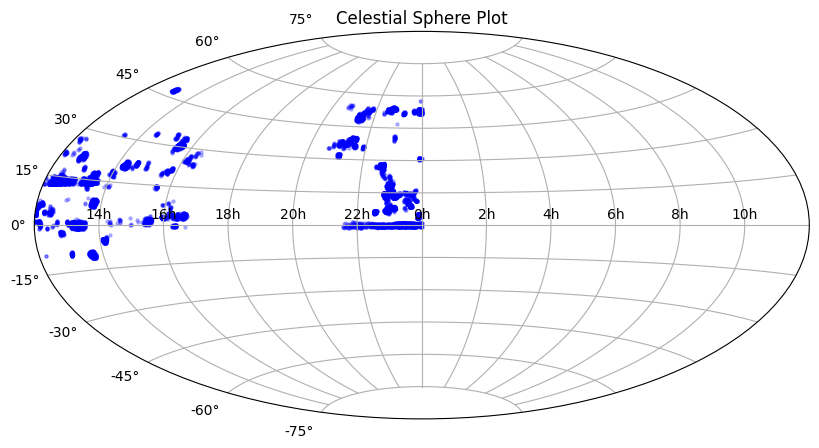

In [58]:
# we know temporal spread of data lets look at spacial distribution

def plot_celestial(ra_deg, dec_deg, title="Celestial Sphere Plot"):
    """Plots RA and Dec on an Aitoff projection."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)
    # Calculate the shift
    shift = ra_deg.median()

    # Apply the shift to RA values
    shifted_ra = (ra_deg + shift) % 360
    # Convert RA to radians
    ra_rad = np.radians(shifted_ra)
    dec_rad = np.radians(dec_deg)

    # Convert RA to -pi to pi range for Aitoff projection and invert
    ra_rad = -ra_rad

    ax.scatter(ra_rad, dec_rad, s=5, alpha=0.25, color='blue')  # Single color for now

    ax.set_title(title)

    # Set tick labels for RA (optional)
    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])

    plt.show()
plot_celestial(df.ra, df.dec, title="Celestial Sphere Plot")

TypeError: Changing axes limits of a geographic projection is not supported.  Please consider using Cartopy.

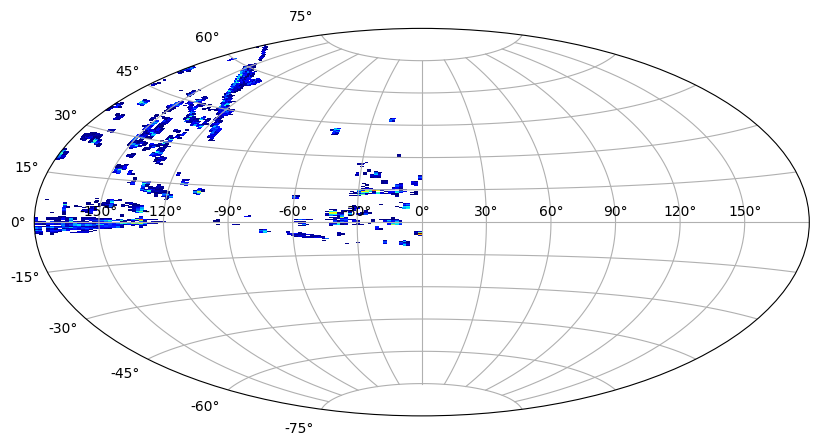

In [60]:
def plot_redshift_map(ra_deg, dec_deg, redshift, title="Redshift Map"):
    """Plots a redshift map on an Aitoff projection (compatible with older Matplotlib)."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='aitoff')
    ax.grid(True)

    # Convert RA and Dec to radians
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)

    # Invert RA for standard orientation
    ra_rad = -ra_rad

    # Create the 2D histogram (density map)
    hist = ax.hist2d(ra_rad, dec_rad, bins=200, cmin=1, cmap='jet')

    # Manually color the bins based on redshift
    counts, xedges, yedges, im = hist
    z_indices = np.digitize(redshift, counts.flatten()) - 1  # Map redshift to bin indices
    z_indices = np.clip(z_indices, 0, len(counts.flatten()) - 1)  # Ensure indices are within bounds

    # Flatten the redshift data to match the bin indices
    z_flattened = redshift

    # Set the color of each bin based on the redshift
    for i in range(len(im.get_array())):
        for j in range(len(im.get_array()[0])):
            bin_index = i * len(im.get_array()[0]) + j
            if counts[i, j] > 0:  # Only color bins with counts
                im.get_array()[i, j] = z_flattened[z_indices[bin_index]]

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Redshift z')

    ax.set_title(title)

    # Set tick labels for RA (optional)
    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])

    plt.show()

# Call the plotting function
plot_redshift_map(df.ra, df.dec, df.redshift)